# WGAN
In GAN's we have two probability distributions, P_g(Probability distribution from the generator) and P_r(Probability distribution from the real image). Now to make realistic images, we want the distance between the probability distributions to be minimum. But, how do we define distance? There exists some common ways from statistics:
- Kullback-Leibler (KL) divergence
- Jensen-Shannon (JS) divergence; (GSN loss used so far is equivalent to JS divergence)
- Wasserstein Distance; (pronounced as 'vassershtaeen' and rhymes with 'Einstein')

## Summary:
JS idvergence has gradients issues leading to unstable training, and WGAN instead bases its loss from Wasserstein Distance

## Characteristics of WGAN
- Better Stability (prevents mode collapse, i.e., the generator gives the same output for different latent space)
- Loss Termination has meaning, i.e., Termination criteria
- Longer to train

In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import make_grid

%matplotlib inline
sns.set()

In [2]:
class Critic(nn.Module):
    def __init__(self, channels, features_d):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            # Input: N x channels x 64 x 64
            nn.Conv2d(
                in_channels=channels,
                out_channels=features_d,
                kernel_size=4,
                stride=2,
                padding=1,
            ), # 32x32
            nn.LeakyReLU(negative_slope=2e-1, inplace=True),
            self._block(in_channels=features_d, out_channels=features_d*2, kernel_size=4, stride=2, padding=1), # 16x16
            self._block(in_channels=features_d*2, out_channels=features_d*4, kernel_size=4, stride=2, padding=1), # 8x8
            self._block(in_channels=features_d*4, out_channels=features_d*8, kernel_size=4, stride=2, padding=1), # 4x4
            nn.Conv2d(
                in_channels=features_d*8,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=0,
            ), #1x1
            # nn.Sigmoid(), no sigmoid at last, for wgan, we work with logits
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.LeakyReLU(negative_slope=2e-1, inplace=True),
        )
            
    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x latent_dim x 1 x 1
            self._block(in_channels=latent_dim, out_channels=features_g*16, kernel_size=4, stride=1, padding=0), # N x f_g*16 x 4 x 4
            self._block(in_channels=features_g*16, out_channels=features_g*8, kernel_size=4, stride=2, padding=1), # 8x8
            self._block(in_channels=features_g*8, out_channels=features_g*4, kernel_size=4, stride=2, padding=1), # 16x16
            self._block(in_channels=features_g*4, out_channels=features_g*2, kernel_size=4, stride=2, padding=1), # 32x32
            nn.ConvTranspose2d(
                in_channels=features_g*2,
                out_channels=channels_img,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
        )
            
    def forward(self, x):
        return self.gen(x)

In [4]:
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 32
LEARNING_RATE = 5e-5
LATENT_DIM = 100
CHANNELS = 1
FEATURES_DISC = 64
FEATURES_GEN = 64
IMG_SIZE = 64
BATCH_SIZE = 32
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 1e-2 # this is to satisfy Lipschitz constraint

In [6]:
transform = transforms.Compose(
    [transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), transforms.Normalize([5e-1 for _ in range(CHANNELS)], [5e-1 for _ in range(CHANNELS)], inplace=True)]
)

In [7]:
# MNIST
dataset = datasets.MNIST(root='./dataset', download=True, train=True, transform=transform)
CHANNELS = 1

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [8]:
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, num_workers=os.cpu_count(), drop_last=True, shuffle=True, pin_memory=True)

In [9]:
fixed_noise = torch.randn((32, LATENT_DIM, 1, 1)).to(DEVICE)

critic = Critic(channels=CHANNELS, features_d=FEATURES_DISC).to(DEVICE)
gen = Generator(latent_dim=LATENT_DIM, channels_img=CHANNELS, features_g=FEATURES_GEN).to(DEVICE)

init_weights(critic)
init_weights(gen)

optim_critic = optim.RMSprop(critic.parameters(), lr=LEARNING_RATE)
optim_gen = optim.RMSprop(gen.parameters(), lr=LEARNING_RATE)

criterion = nn.BCELoss()

# training mode
critic.train()
gen.train() 

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpla

In [10]:
fake_imgs = []
for epoch in range(1, EPOCHS + 1):
    for batch_idx, (real_img, _) in enumerate(loader):
        real_img = real_img.to(DEVICE)
        
        # train the critic: max E[critic(x)] - E[critic(z)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(DEVICE)
            fake_img = gen(noise)
            
            critic_real = critic(real_img).view(-1)
            critic_fake = critic(fake_img.detach()).view(-1)

            # we want to maximize (torch.mean(critic_real) - torch.mean(critic_fake)), which is equivalent to minimize the negative 
            lossC = -(torch.mean(critic_real) - torch.mean(critic_fake))

            critic.zero_grad()
            lossC.backward(retain_graph=True)
            optim_critic.step()
            
            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP) # we are clipping so that Lipschitz constraint is satisfied 
        
        # train the generator: min -E[critic(gen(z))]
        output = critic(fake_img).view(-1)
        lossG = -torch.mean(output)
        
        gen.zero_grad()
        lossG.backward()
        optim_gen.step()
                
        if batch_idx == len(loader) - 1:
            print(f'Epoch: [{epoch}/{EPOCHS}] | LossC: {lossC:.4f} | LossG: {lossG:.4f}')
            with torch.inference_mode():
                fake_img = gen(fixed_noise)
                
                img_grid_fake = make_grid(fake_img[:32], normalize=True)

                fake_imgs.append(img_grid_fake)

Epoch: [1/32] | LossC: -1.5413 | LossG: 0.7245
Epoch: [2/32] | LossC: -1.5162 | LossG: 0.7163
Epoch: [3/32] | LossC: -1.0767 | LossG: 0.6100
Epoch: [4/32] | LossC: -0.9356 | LossG: 0.3757
Epoch: [5/32] | LossC: -1.0387 | LossG: 0.5496
Epoch: [6/32] | LossC: -0.8856 | LossG: 0.5718
Epoch: [7/32] | LossC: -0.9720 | LossG: 0.5462
Epoch: [8/32] | LossC: -0.8785 | LossG: 0.5533
Epoch: [9/32] | LossC: -0.8726 | LossG: 0.5545
Epoch: [10/32] | LossC: -0.8223 | LossG: 0.5566
Epoch: [11/32] | LossC: -0.8219 | LossG: 0.2874
Epoch: [12/32] | LossC: -0.7916 | LossG: 0.5020
Epoch: [13/32] | LossC: -0.8152 | LossG: 0.5034
Epoch: [14/32] | LossC: -0.7586 | LossG: 0.2406
Epoch: [15/32] | LossC: -0.7473 | LossG: 0.1628
Epoch: [16/32] | LossC: -0.8760 | LossG: 0.5019
Epoch: [17/32] | LossC: -0.7597 | LossG: 0.1865
Epoch: [18/32] | LossC: -0.6924 | LossG: 0.5083
Epoch: [19/32] | LossC: -0.8635 | LossG: 0.4933
Epoch: [20/32] | LossC: -0.6896 | LossG: 0.2261
Epoch: [21/32] | LossC: -0.6484 | LossG: 0.5014
E

(-0.5, 529.5, 265.5, -0.5)

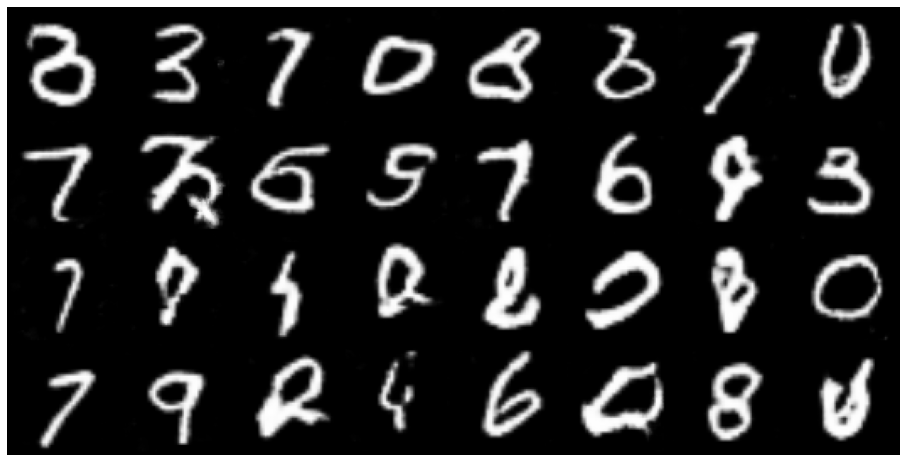

In [11]:
plt.figure(figsize=(16, 16))
plt.imshow(fake_imgs[-1].cpu().numpy().transpose((1, 2, 0)))
plt.axis('off')